## 1.2 Label propagation: segmentation using just position information

In [20]:
# Import Libraries
import os
from pathlib import Path
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle

In [3]:
# Get the current working directory
cwd = os.getcwd()
print(cwd)

d:\VS_Projects\MIRA_MISA_LABS\MISA_LAB3


### Read new test images to perform the segmentation

In [5]:
# Read patients in the test-set
test_set_path = 'data/testing-set'
aux_patients_list = os.listdir(test_set_path + '/testing-images')
list_patient = []
for str1 in aux_patients_list:
    list_patient.append(str1.replace(".nii.gz", ""))

## Preprocessing -- Skull removal step
def skull_removal(img, mask):
    brain_mask = mask>=1
    skull_strip = img*(brain_mask)
    return skull_strip

# Save array as a new nifti image
def save_as_nifti(array, filename, reference_image):
    """Save array as nifti image

    Args:
        array (array): array to be saved
        filename (str): path to save
        reference_image (str): path of reference image
    """
    reference_image = sitk.ReadImage(reference_image)
    image = sitk.GetImageFromArray(array)
    image.SetOrigin(reference_image.GetOrigin())
    image.SetSpacing(reference_image.GetSpacing())
    image.SetDirection(reference_image.GetDirection())
    sitk.WriteImage(image, filename)

def image_registration(fixed_path, moving_path):
    """Give two images and the registration of both, and its transformation map will be given

    Args:
        fixed_path (str): fixed (template) image
        moving_path (str): moving image (image that will be transformed)

    Returns:
        sitk image, transformix map: transformed image and the transformation map
    """

    fixedImage = sitk.ReadImage(fixed_path)
    movingImage = sitk.ReadImage(moving_path)

    #Start registration settings
    elastixImageFilter = sitk.ElastixImageFilter() #Image filter object
    #Defining settings
    elastixImageFilter.SetFixedImage(fixedImage)
    elastixImageFilter.SetMovingImage(movingImage)

    #Run registration
    elastixImageFilter.Execute()

    #Get result image
    resultImage = elastixImageFilter.GetResultImage()

    #Transformation map
    transformParameterMap = elastixImageFilter.GetTransformParameterMap()
    #Set resampler interpolator as NearestNeighbor
    transformParameterMap[0]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    transformParameterMap[1]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]    
    transformParameterMap[2]["ResampleInterpolator"] = ["FinalNearestNeighborInterpolator"]
    return resultImage, transformParameterMap

In [26]:
# TRansform atlas images to the same space as the fixed image per each image
atlas_path_csf = str(cwd) + f'/data/our_atlas/csf_atlas.nii'
atlas_path_gm = str(cwd) + f'/data/our_atlas/gm_atlas.nii'
atlas_path_wm = str(cwd) + f'/data/our_atlas/wm_atlas.nii'

def transform_atlas(atlas_path_csf, atlas_path_gm, atlas_path_wm, transformParameterMap):

    atlas_csf = sitk.ReadImage(atlas_path_csf) #Read labels
    atlas_gm = sitk.ReadImage(atlas_path_gm) #Read labels
    atlas_wm = sitk.ReadImage(atlas_path_wm) #Read labels
    
    transformixImageFilter = sitk.TransformixImageFilter() #Create object transform matrix
    transformixImageFilter.SetTransformParameterMap(transformParameterMap) #Set with found transform map
    transformixImageFilter.SetMovingImage(atlas_csf) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_csf_registered = transformixImageFilter.GetResultImage() #Get result image

    transformixImageFilter.SetMovingImage(atlas_gm) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_gm_registered = transformixImageFilter.GetResultImage() #Get result image

    transformixImageFilter.SetMovingImage(atlas_wm) #set moving image
    transformixImageFilter.Execute() # Execute transform
    atlas_wm_registered = transformixImageFilter.GetResultImage() #Get result image

    return atlas_csf_registered, atlas_gm_registered, atlas_wm_registered   
    
# Go through all the patients in the test-set
for patient in list_patient:
    print(patient)
    # Read the images
    fixed_path = str(cwd) + f'/data/testing-set/testing-images/{patient}.nii.gz'
    labels_path = str(cwd) + f'/data/testing-set/testing-labels/{patient}_3C.nii.gz'
    moving_path = str(cwd) + f'/data/training-set/training-images/1011.nii.gz'
    # Register the images
    resultImage, transformParameterMap = image_registration(fixed_path, moving_path)
    # Transform the atlas images
    atlas_csf_registered, atlas_gm_registered, atlas_wm_registered = transform_atlas(atlas_path_csf, atlas_path_gm, atlas_path_wm, transformParameterMap)
    # Save the transformed atlas images
    save_as_nifti(sitk.GetArrayFromImage(atlas_csf_registered), f'data/transformed_atlas/csf_atlas_{patient}.nii.gz', fixed_path)
    save_as_nifti(sitk.GetArrayFromImage(atlas_gm_registered), f'data/transformed_atlas/gm_atlas_{patient}.nii.gz', fixed_path)
    save_as_nifti(sitk.GetArrayFromImage(atlas_wm_registered), f'data/transformed_atlas/wm_atlas_{patient}.nii.gz', fixed_path)

1003
1004
1005
1018
1019
1023
1024
1025
1038
1039
1101
1104
1107
1110
1113
1116
1119
1122
1125
1128


### Apply Segmentation using transformed atlasses

In [18]:
def dice_score(image1, image2):
    image1 = sitk.GetArrayFromImage(image1)
    image2 = sitk.GetArrayFromImage(image2)
    image1[image1 > 0] = 1
    image2[image2 > 0] = 1
    intersection = np.sum(np.multiply(image1, image2))
    dice = 2 * intersection / (np.sum(image1) + np.sum(image2))
    return dice

def get_dice_score(list_patient):
    ds_csf = []
    ds_gm = []
    ds_wm = []

    for i in range(len(list_patient)):
        seg_path = str(cwd) + f'/data/LP_segmentation/atlas_labels_{list_patient[i]}.nii.gz'
        label_path = str(cwd) + f'/data/testing-set/testing-labels/{list_patient[i]}_3C.nii.gz'
        seg_image = sitk.ReadImage(seg_path)
        label_image = sitk.ReadImage(label_path)
        for i in range(1, 4):
            d = dice_score(seg_image == i, label_image == i)
            if i == 1:
                ds_csf.append(d)
            elif i == 2:
                ds_gm.append(d)
            else:
                ds_wm.append(d)

    # save the dice scores as a csv file
    df = pd.DataFrame({'CSF': ds_csf, 'GM': ds_gm, 'WM': ds_wm})
    df.to_csv(str(cwd) + f'/data/LP_segmentation/dice_scores.csv', index=False)

    return df

In [74]:
# Apply segmentation using the transformed atlas images
def segmentation(list_patient):
    for p in list_patient:
        # Read transformed atlas images
        # Atlasses registered to the template space (1011.nii.gz)
        atlas_csf = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/csf_atlas_{p}.nii.gz')
        atlas_gm = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/gm_atlas_{p}.nii.gz')
        atlas_wm = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/wm_atlas_{p}.nii.gz')

        # Read the image to be segmented
        fixed_path = str(cwd) + f'/data/testing-set/testing-images/{p}.nii.gz'
        mask_path = str(cwd) + f'/data/testing-set/testing-mask/{p}_1C.nii.gz'
        mask_array = sitk.GetArrayFromImage(sitk.ReadImage(str(mask_path)))
        
        # select the maximum value of the atlas images to perform segmentation
        atlas_csf1 = sitk.GetArrayFromImage(atlas_csf)
        atlas_gm1 = sitk.GetArrayFromImage(atlas_gm)
        atlas_wm1 = sitk.GetArrayFromImage(atlas_wm)

        # get the tissue with the highest value
        array = [atlas_csf1, atlas_wm1, atlas_gm1]

        # get the tissue with the highest value (GET ATLAS LABELS)   
        atlas_labels = np.argmax(array, axis=0)+1 # add 1 to get the labels 1, 2, 3 not 0, 1, 2

        # mask the atlas
        # in this way, we can make sure that the segmentation is only performed in the brain
        atlas_labels = atlas_labels * mask_array

        # save the atlas labels as a nifti file
        save_as_nifti(atlas_labels, f'data/LP_segmentation/atlas_labels_{p}.nii.gz', fixed_path)


[1 2 3]


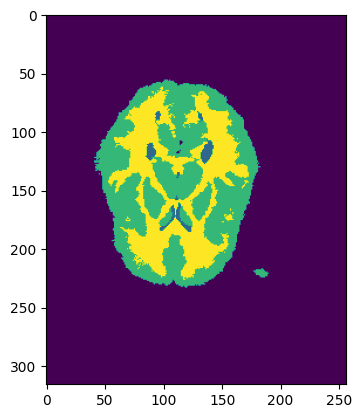

In [13]:
# Test
# p =1003
# atlas_csf_registered = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/csf_atlas_{p}.nii.gz')
# atlas_gm_registered = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/gm_atlas_{p}.nii.gz')
# atlas_wm_registered = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/wm_atlas_{p}.nii.gz')

# # Read the image to be segmented
# fixed_path = str(cwd) + f'/data/testing-set/testing-images/{p}.nii.gz'

# # select the maximum value of the atlas images to perform segmentation
# atlas_csf_registered1 = sitk.GetArrayFromImage(atlas_csf_registered)
# atlas_gm_registered1 = sitk.GetArrayFromImage(atlas_gm_registered)
# atlas_wm_registered1 = sitk.GetArrayFromImage(atlas_wm_registered)

# # get the tissue with the highest value
# array = [atlas_csf_registered1, atlas_gm_registered1, atlas_wm_registered1]

# # get sum of the atlasses to make a mask
# sum_atlas = atlas_csf_registered1 + atlas_gm_registered1 + atlas_wm_registered1
# sum_atlas[sum_atlas > 0] = 1
# plt.imshow(sum_atlas[150, :, :])
# atlas_labels = np.argmax(array, axis=0)+1
# plt.imshow(atlas_labels[150, :, :])
# print(np.unique(atlas_labels))
# atlas_labels = atlas_labels * sum_atlas
# plt.imshow(atlas_labels[150, :, :])

# save_as_nifti(atlas_labels, f'data/LP_segmentation/atlas_labels_{p}.nii.gz', fixed_path)

# ds_csf = []
# ds_gm = []
# ds_wm = []
# label_path = str(cwd) + f'/data/testing-set/testing-labels/{p}_3C.nii.gz'
# seg_path = str(cwd) + f'/data/LP_segmentation/atlas_labels_{p}.nii.gz'
# label_image = sitk.ReadImage(label_path)
# seg_image = sitk.ReadImage(seg_path)
# for i in range(1, 4):
#     d = dice_score(seg_image == i, label_image == i)
#     if i == 1:
#         ds_csf.append(d)
#     elif i == 2:
#         ds_gm.append(d)
#     else:
#         ds_wm.append(d)
# df = pd.DataFrame({'CSF': ds_csf, 'GM': ds_gm, 'WM': ds_wm})

In [75]:
segmentation(list_patient)

In [76]:
# Get dice score from the label propagation segmentation results
get_dice_score(list_patient)

,CSF,GM,WM
0,0.439877,0.777066,0.835525
1,0.678879,0.773909,0.828754
2,0.777628,0.738967,0.809919
3,0.764978,0.775809,0.837349
4,0.558133,0.754281,0.823781
5,0.403807,0.772223,0.833666
6,0.689614,0.767821,0.838514
7,0.743337,0.733339,0.816024
8,0.766278,0.778552,0.839697
9,0.547714,0.756081,0.815698


## 1.3 Bayesian Approach: Combine tissue models and label propagation segmentations (segmentation using intensity + position information)

In [84]:
# Obtain P( Y | X ) from Tissue models.
# load the tissue models

def enlarge(lookup_table, max_value):
    if max_value > len(lookup_table):
        # extend the lookup table accordingly.
        zeros = np.zeros(max_value-len(lookup_table)+1)
        lookup_table = np.append(lookup_table, np.array(zeros) ) # the filling for the exceptional intensities.
    return lookup_table

## Preprocessing -- skull removal step
def skull_removal(img, mask):
    brain_mask = mask>=1
    skull_strip = img*(brain_mask)
    return skull_strip

def get_tissue_model(list_patient):
    ds_csf = []
    ds_gm = []
    ds_wm = []
    for p in list_patient:
        with open(str(cwd) + '/data/our_tissue_models/tissue_model.p', 'rb') as f:
            tissue_models = pickle.load(f)

        fixed_path = str(cwd) + f'/data/testing-set/testing-images/{p}.nii.gz'
        mask_path = str(cwd) + f'/data/testing-set/testing-mask/{p}_1C.nii.gz'
        mask_array = sitk.GetArrayFromImage(sitk.ReadImage(str(mask_path)))

        fixed_image = sitk.ReadImage(fixed_path)
        img_array = sitk.GetArrayFromImage(fixed_image)

        # Preprocessing - skull stripping
        img_array = skull_removal(img_array, mask_array)

        # check the image maximum intensity
        max_value = int(np.max(img_array))
        max_value = max_value+1

        tissue_models = np.array(tissue_models)

        # get the probability of each tissue
        # lookup tables
        prob_csf = tissue_models[:, 0]
        prob_wm = tissue_models[:, 1]
        prob_gm = tissue_models[:, 2]

        # Enlarge the lookup tables
        prob_csf = enlarge(prob_csf, max_value)
        prob_wm = enlarge(prob_wm, max_value)
        prob_gm = enlarge(prob_gm, max_value)

        # Get the probablity image for each tissue
        array_int = np.array(img_array, dtype="uint16")
        prob_csf = prob_csf[array_int]
        prob_wm = prob_wm[array_int]
        prob_gm = prob_gm[array_int]

        # Read P(X): Probablistic atlasses per each tissue
        # probablity images
        atlas_csf = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/csf_atlas_{p}.nii.gz')
        atlas_gm = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/gm_atlas_{p}.nii.gz')
        atlas_wm = sitk.ReadImage(str(cwd) + f'/data/transformed_atlas/wm_atlas_{p}.nii.gz')

        # Calculate Bayesian probability
        # Multiply two probablity images element-wise
        bayesian_csf = prob_csf * sitk.GetArrayFromImage(atlas_csf)
        bayesian_gm = prob_gm * sitk.GetArrayFromImage(atlas_gm)
        bayesian_wm = prob_wm * sitk.GetArrayFromImage(atlas_wm)

        # Get the tissue with the highest value
        array = [bayesian_csf, bayesian_wm, bayesian_gm]
        bayesian_labels = np.argmax(array, axis=0)+1

        # use the mask provided
        bayesian_labels = bayesian_labels * mask_array

        # Show the results
        plt.imshow(bayesian_labels[150, :, :])

        # Calculete dice score
        label_path = str(cwd) + f'/data/testing-set/testing-labels/{p}_3C.nii.gz'
        label_image = sitk.ReadImage(label_path)
        bayesian_labels = sitk.GetImageFromArray(bayesian_labels)

        for i in range(1, 4):
            d = dice_score(bayesian_labels == i, label_image == i)
            if i == 1:
                ds_csf.append(d)
            elif i == 2:
                ds_gm.append(d)
            else:
                ds_wm.append(d)

        # Save the results
        sitk.WriteImage(bayesian_labels, str(cwd) + f'/data/Bayesian_segmentation/bayesian_results_{p}.nii.gz')

    df = pd.DataFrame({'CSF': ds_csf, 'GM': ds_gm, 'WM': ds_wm})
    df.to_csv(str(cwd) + f'/data/Bayesian_segmentation/dice_scores.csv', index=False)
    return df

,CSF,GM,WM
0,0.450721,0.851408,0.876274
1,0.720180,0.916786,0.941449
2,0.882810,0.889172,0.928689
3,0.746336,0.901375,0.927728
4,0.635222,0.899605,0.936974
5,0.435463,0.901950,0.921707
6,0.724909,0.905299,0.935315
7,0.856796,0.884210,0.931641
8,0.736820,0.911627,0.937731
9,0.600425,0.897298,0.928923


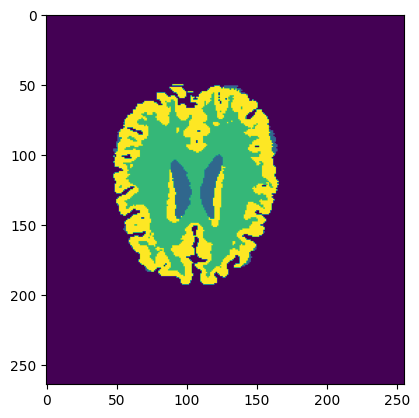

In [85]:
get_tissue_model(list_patient)

In [86]:
# Read the csv results
df = pd.read_csv(str(cwd) + '/data/Bayesian_segmentation/dice_scores.csv')
df

,CSF,GM,WM
0,0.450721,0.851408,0.876274
1,0.720180,0.916786,0.941449
2,0.882810,0.889172,0.928689
3,0.746336,0.901375,0.927728
4,0.635222,0.899605,0.936974
5,0.435463,0.901950,0.921707
6,0.724909,0.905299,0.935315
7,0.856796,0.884210,0.931641
8,0.736820,0.911627,0.937731
9,0.600425,0.897298,0.928923
